## Compute image statistics计算图像数据的统计信息
**Do not use augmentation here!在这里不使用数据增强**

Calculating statistics will give channel averages of [0.702447, 0.546243, 0.696453] (图像每个通道的平均值),
and std's of [0.238893, 0.282094, 0.216251] (图像每个通道的方差).

While we are calculating statistics, we can check if there are images that have a very low maximum pixel intensity (almost totally black) or very high minimum pixel intensity (almost totally white). These kind of images could be caused by bad exposure or cropping to an empty area. In case of an empty area, the image would not be an outlier but equally valid negative sample.  
在我们计算统计数据的同时，我们可以检查是否存在具有最大像素值非常低的（几乎全黑）或最小像素值非常高的（几乎全白）的图像。 这些图像可能是由于曝光不良或裁剪到空白区域造成的。 在空白区域的情况下，图像不是异常值，而是同样有效的负样本。  

We find that there is at least one very dark and 6 very bright images.  
我们发现至少有一个非常暗的图像和6个非常明亮的图像。

In [8]:
import h5py
import numpy as np
from tqdm import tqdm_notebook
from matplotlib.font_manager import *  

import imgaug.augmenters as iaa
import numpy as np


def augment_images(images: np.ndarray, center_crop_size=(48, 48)):
    # center crop
    cropped: np.ndarray = np.zeros(shape=(images.shape[0], center_crop_size[0], center_crop_size[1], images.shape[-1]),
                                   dtype=np.uint8)
    for i in range(len(images)):
        centerw, centerh = images[i].shape[0] // 2, images[i].shape[1] // 2
        halfw, halfh = center_crop_size[0] // 2, center_crop_size[1] // 2
        cropped[i] = images[i][centerw - halfw: centerw + halfw,
                     centerh - halfh: centerh + halfh, :]
    seq = iaa.Sequential([
        #         iaa.Crop(px=(0, 16), keep_size=True, name="crop"),
        iaa.Fliplr(0.5, name="Flipper_h"),
        iaa.Flipud(0.5, name="Flipper_V"),
        #         iaa.GaussianBlur((0, 3.0), name="GaussianBlur"),
        iaa.Dropout(0.02, name="Dropout"),
        iaa.AdditiveGaussianNoise(scale=0.01 * 255, name="MyLittleNoise"),
        iaa.AdditiveGaussianNoise(loc=32, scale=0.0001 * 255, name="SomeOtherNoise"),
        iaa.AffineCv2(
            #                       scale=(0.8, 1.1),
            rotate=(-30, 30), name="affine_rotate", cval=(100, 200),
            translate_px={"x": (-10, 10), "y": (-10, 10)}
        )
    ])
    seq_det = seq.to_deterministic()  # call this for each batch again, NOT only once at the start
    return seq_det.augment_images(cropped)

myfont = FontProperties(fname='simhei.ttf') 
# f=h5py.File('histo/histro_train.h5','r')
# print(f['train_images14'].shape,f['train_labels14'].shape)

In [9]:
with h5py.File('histo/histro_train.h5','r') as f:
    img=f['train_images14'][0]
    xx=augment_images(img[np.newaxis,...])

In [10]:
img.shape
img=np.swapaxes(img,0,1)
# img=np.swapaxes(img,0,1)
img.shape

(96, 96, 3)

In [11]:
# 计算图像每个通道的平均值和方差，并找出异常图片。
# fan:如果明白了这个环节的内容并想不运行下面耗时的代码，可以直接令：
channel_avr = [0.70244707, 0.54624322, 0.69645334]
channel_std = [0.23889325, 0.28209431, 0.21625058]
too_dark_idx = ['9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
too_bright_idx = ['c448cd6574108cf14514ad5bc27c0b2c97fc1a83', '9071b424ec2e84deeb59b54d2450a6d0172cf701', 'f6f1d771d14f7129a6c3ac2c220d90992c30c10b', '5a268c0241b8510465cb002c4452d63fec71028a', '5f30d325d895d873d3e72a82ffc0101c45cba4a8', '54df3640d17119486e5c5f98019d2a92736feabc']
# 这样可以不用运行求均值、方差的代码 继续学习后面环节的代码，而不报错。

# # As we count the statistics, we can check if there are any completely black or white images 在统计数据时，我们可以检查是否有完全黑色或白色的图像
dark_th = 10 / 255      # If no pixel reaches this threshold, image is considered too dark 如果一张图片所有像素都低于此阈值，则图像被认为太暗
bright_th = 245 / 255   # If no pixel is under this threshold, image is considerd too bright 如果一张图片所有像素都高于此阈值，则认为图像太亮
too_dark_idx = [] # 太暗图片的名字列表
too_bright_idx = []  # 太亮图片的名字列表

# x_tot = np.zeros(3)
# x2_tot = np.zeros(3)
# counted_ones = 0
# for xxx in tqdm_notebook(range(1, 21), 'computing statistics...(220025 it total)'):
#     for i, idx in enumerate(range(f[f'train_images{xxx}'].shape[0])):  # tqdm_notebook可用于显示进度条，其第二个参数是提示用的
#             #     path = os.path.join(train_path, idx) # 将训练集路径与反例图片名 拼接起来
#             #     # 执行自定义的函数，不做数据增强，但做归一化，并将图像的形状从(96,96,3) 转成 (9216,3)
#             imagearray = f[f'train_images{xxx}'][idx].reshape(-1, 3) / 255
    
#             #     # is this too dark 如果图像太暗了
#             if (imagearray.max() < dark_th):  # 如果图像像素值最大的也比 设定的最小阈值小
#                 too_dark_idx.append(f'{xxx}-{idx}')  # 把这张图片的名字记录在小本本上
#                 continue  # do not include in statistics 跳过本次循环，不将其纳入后面的求平均、求方差
    
#             #     # is this too bright 如果图像太亮了
#             if (imagearray.min() > bright_th):  # 如果图像像素值最小的也比 设定的最大阈值大
#                 too_bright_idx.append(f'{xxx}-{idx}')  # 把这张图片的名字记录在小本本上
#                 continue  # do not include in statistics 跳过本次循环，不将其纳入后面的求平均、求方差
    
#             #     # 统计 ： 用于数据的标准化
#             x_tot += imagearray.mean(axis=0)  # 每个样本的 对应通道的像素值的平均值之和 最后维度是(3,)
#             x2_tot += (imagearray ** 2).mean(axis=0)  # 每个样本的 对应通道的像素值的平方的平均值之和  最后维度是(3,)
#             counted_ones += 1  # 正常图片的个数
# #     if counted_ones > 100 : break

# channel_avr = x_tot / counted_ones  # 每个通道的像素值平均值 最后维度是(3,)
# # # 这一步是计算[E(x)]^2
# channel_std = np.sqrt(x2_tot / counted_ones - channel_avr ** 2)  # 每个通道的像素值标准差 最后维度是(3,)
# # # 方差公式：D(X) = E(X^2) - [E(x)]^2
# print(channel_avr, channel_std, counted_ones)
# (array([0.70244707, 0.54624322, 0.69645334]),
#  array([0.23889325, 0.28209431, 0.21625058]))

In [18]:
print('There was {0} extremely dark image'.format(len(too_dark_idx))) # 太暗的图像的个数
print('and {0} extremely bright images'.format(len(too_bright_idx))) # 太亮的图像的个数
print('Dark one:') 
print(too_dark_idx) # 打印太暗图片的名字
print('Bright ones:') # 打印太亮图片的名字
print(too_bright_idx) 

There was 0 extremely dark image
and 0 extremely bright images
Dark one:
[]
Bright ones:
[]


## Plot some of the very bright or very dark images看看这些太亮和太暗的图片

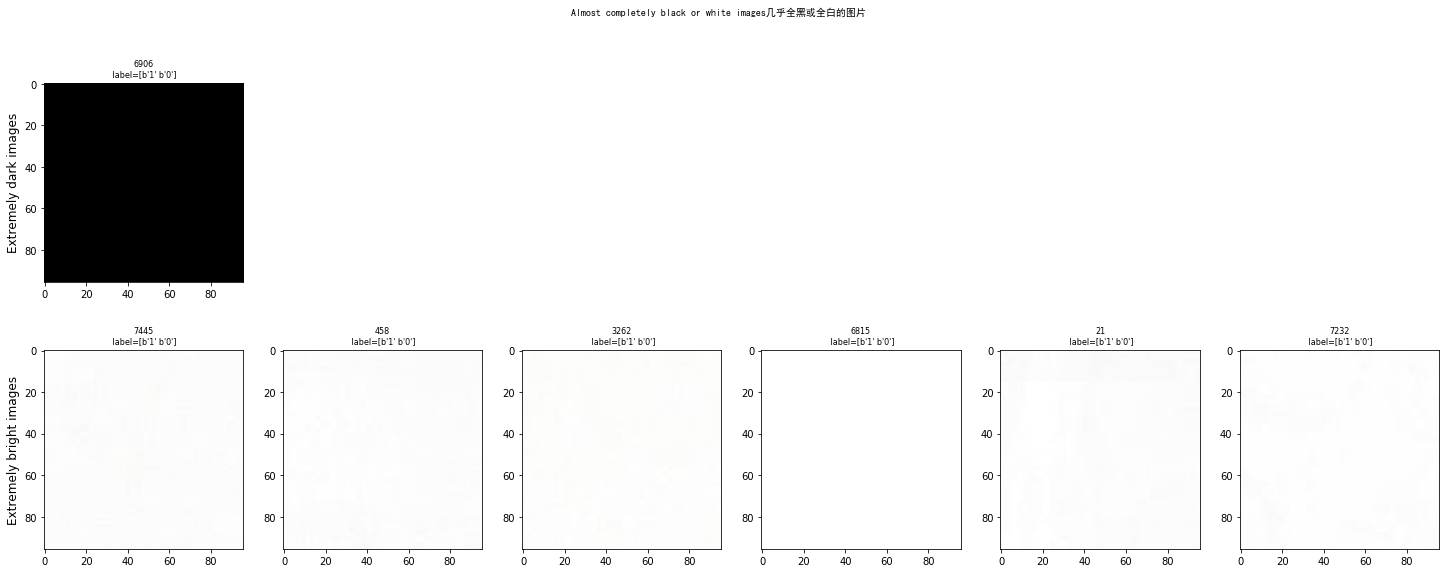

In [56]:
# 展示异常图片

fig, ax = plt.subplots(2,6, figsize=(25,9))
# matpoltlib subplots :创建一系列的子图  nrows子图行的个数，ncols子图列的个数 ,figsize画布尺寸, axes子图的轴， fig图
fig.suptitle('Almost completely black or white images几乎全黑或全白的图片',fontsize=20,fontproperties=myfont) # 标题

# Too dark 展示全局太暗的图片
i = 0
for xxx in too_dark_idx: # 遍历太暗的图像 最多只展示6张图片，多了会使图片太小不好看
    process, idx = xxx.split('-')
    ax[0,i].imshow(f[f'train_images{process}'][int(idx)]) # 在[0,i]子图处 展示这张图片，不使用图像增强
    ax[0,i].set_title(idx + '\n label=' + str(f[f'train_labels{process}'][int(idx)]), fontsize = 8) # 给坐标为(0,i)子图设置标题
    i += 1 
ax[0,0].set_ylabel('Extremely dark images', size='large') # 给坐标为(0,0)图像设置y轴标题
for j in range(min(6, len(too_dark_idx)), 6): # 原画布一行是6个子图，不满6个的子图不应显示
    ax[0,j].axis('off') # hide axes if there are less than 6 # 让这些没有图片的轴不显示
    
# Too bright 展示全局太亮的图片
i = 0
for xxx in too_bright_idx: # 遍历太亮的图像 最多只展示6张图片，多了图片太小不好看了
    process, idx = xxx.split('-')
    ax[1,i].imshow(f[f'train_images{process}'][int(idx)]) # 展示这张图片，不使用图像增强
    ax[1,i].set_title(idx + '\n label=' + str(f[f'train_labels{process}'][int(idx)]), fontsize = 8) # 给坐标为(0,i)图像设置标题
    i += 1
ax[1,0].set_ylabel('Extremely bright images', size='large') # 给坐标为(1,0)图像设置y轴标题
for j in range(min(6, len(too_bright_idx)), 6): # 遍历没有图像的轴(当然这里太亮的图片数量刚好是6，range(6,6)就不用遍历了)
    ax[1,j].axis('off') # hide axes if there are less than 6 # 让这些没有图片的轴不显示

In [14]:
print("julyedu")

julyedu


All the dark and bright images are labeled negative. I think the bright ones are just cropped from a non-stained part or they don't have any tissue (plain glass?) so the labels are correct. The samples don't have tumor tissue present. I am not so sure about the dark image, is it an outlier crop from badly exposed area or just some very large cell part filling the whole image. Anyway, removing only a small amount of outliers from this size data set has little or no effect on the prediction performance.  
对异常图片的分析：所有过于黑暗和明亮的图像都标记为反例样本。 我认为明亮的那些只是从未染色的部分裁剪或他们没有任何组织（普通玻璃？）所以反例标记是正确的，即样本不存在肿瘤组织。 我不太确定黑暗的图像，它是来自暴露严重区域的异常剪切，还是只是填充整个图像的一些非常大的细胞部分。无论如何，<font color='blue'>从该大小数据集中仅去除少量异常值对预测性能几乎没有影响或没有影响。</font>  
fan:  
有些人建议保留这些异常值：  
How I drop from 0.9805 Private LB to 0.974 (113rd Solution)反思  
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/87367#latest-504483

# Prepare the data and split train准备数据和拆分训练集
Split train data to 90% training and 10% validation parts. We want to maintain equal ratios of negative/positive (60/40) in both, training and test splits. This is not so crucial here as both labels are almost equally represented but in case we had a rare class, random split could cause severe underrepresentation or in worst case, leave all rare classes out of one split.   
将训练数据集分成90％用于训练和10％用于验证。 我们希望在训练和验证集中数据保持相等的 反例/正例为（6/4）比率。 这里并不是那么重要，因为两个标签数量几乎都是相同的，但是假设我们有一个罕见的类别，随机分割训练集可能会导致严重的代表性不足，或者在最坏的切分情况下，某个切分数据集中一个罕见类别都可能没有。

In [3]:
# 使用sklearn等比例切分数据集。不直接使用fastai切分数据集的原因是，fastai没有等比例切分方法，
#而sklearn的train_test_split有stratify这个参数。

from sklearn.model_selection import train_test_split # 分割训练集、测试集的方法

# we read the csv file earlier to pandas dataframe, now we set index to id so we can perform
# 我们之前读取了pandas dataframe的csv文件，现在我们将id列作为索引列
train_df = data.set_index('id') 

# If removing outliers, uncomment the four lines below
#如果要删除离群值(异常值，即上面的太黑太白图片)，需要将下面四句话取消注释(实际上下面被注释掉了)
# print('Before removing outliers we had {0} training samples.'.format(train_df.shape[0])) # 打印 在删除离群值之前，我们的训练集有多少条数据
# train_df = train_df.drop(labels=too_dark_idx, axis=0) # 删除训练集中太黑的图片
# train_df = train_df.drop(labels=too_bright_idx, axis=0) # 删除训练集中太亮的图片
# print('After removing outliers we have {0} training samples.'.format(train_df.shape[0])) #  打印 在删除离群值之后，训练集还有多少条数据

train_names = train_df.index.values # 构建训练集的图像名数组
train_labels = np.asarray(train_df['label'].values) # 构建训练图像对应的标记数组

# split, this function returns more than we need as we only need the validation indexes for fastai 
# split，这个函数的返回值 比我们需要的多，因为我们只需要验证集的索引(val_idx)，把它给fastai库,再来切分数据集
# Split the train and the validation set for the fitting将原训练集分割成训练集和验证集,test_size是验证集占原来数据集的比例
# stratify是为了保持split前类的分布比例。 https://www.e-learn.cn/content/qita/780160
# random_state 可复现的随机切分方式
tr_n, tr_idx, val_n, val_idx = train_test_split(train_names, range(len(train_names)), test_size=0.1, stratify=train_labels, random_state=123)
# train_test_split第一个参数是样本X，第二个参数本应是标记Y，但这里是0~len(train_names)-1，即索引。
# tr_n是训练集样本，tr_idx是训练集标记，val_n是验证集样本，val_idx是验证集标记(这里是数字索引，也是我们最终需要的，用于传到fastai库中再做实际上的数据集切分)

NameError: name 'data' is not defined

In [16]:
print("julyedu")

julyedu


In [12]:
# 本小节之后的内容主要是讲用fastai加载数据、切分数据、增加测试集、生成databunch等
# 相关内容可以查看官方文档
# https://docs.fast.ai/data_block.html#The-data-block-API 


# fastai 1.0
from fastai import * # 更快、更简单、更先进的深度学习库
from fastai.vision import * # fastai中包含定义计算机视觉中的数据集和训练模型所必须的函数
from torchvision.models import *    # import *=all the models from torchvision  pytorch计算机视觉模型

BATCH_SIZE = 128                    # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
# 指定批量大小，这个参数对硬件有限制。 批量设置大了可能会耗尽GPU内存。
# 自定义数据增强函数(也可以使用fastai里面的图像增强api)

import random # 生成随机变量
ORIGINAL_SIZE = 96      # original size of the images - do not change原始图片尺寸

# AUGMENTATION VARIABLES # 数据增强的变量
CROP_SIZE = 90          # final size after crop剪裁后的图片大小
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change旋转角度

RANDOM_SHIFT = 2        #> center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
# 随机平移0到2个像素值

RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change 随机亮度 给图像每个像素加上一个在(-1,1)间的随机值
RANDOM_CONTRAST = 5    # range (0-100), 0=no change 随机对比度 给图像每个像素乘上一个在(0,2)间的随机值
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right向左或右旋转90度
sz = CROP_SIZE                      # input size is the crop size 输入的图像尺寸 (图像增强后是90*90)

We load the images to an ImageDataBunch for the training. This fastai's data object is easily customized for loading images using our own `readCroppedImage` function. We just need to subclass ImageList. 
[ImageList API docs](https://docs.fast.ai/vision.data.html#ItemList-specific-to-vision)  
我们将图像加载到ImageDataBunch进行训练。 使用我们自己的`readCroppedImage`函数加载图像，这个fastai的数据对象很容易自定义。 我们只需要继承ImageList。

In [34]:
# create dataframe for the fastai loader 创建一个训练集dataframe 用于 fastai数据加载
# train_dict = {'name': train_path + train_names, 'label': train_labels} # 创建一个字典 name：训练集地址+图像名  label:图像对应的标记
# df = pd.DataFrame(data=train_dict) # 创建一个训练集dataframem，列名是name、label

# create test dataframe 创建测试集dataframe
test_names = []
for f in os.listdir(test_path): # os.listdir返回一个列表包含某路径下所有图像名
    test_names.append(test_path + f) # 将测试集路径和测试图像名组合成一个字符串 追加到列表中
df_test = pd.DataFrame(np.asarray(test_names), columns=['name'])  # 创建一个dataframe，列名是name，数据是测试集的地址+图像名

In [14]:
from fastai.vision import get_files, ImageList, Path, Image, tensor, df_names_to_idx
import numpy as np
import os
import h5py

class H5pyList(ImageList):
    
    def open(self, fn, dsn, imgidx):
        with h5py.File(fn, 'r') as f:
            img=f[dsn][imgidx][()]
            img=augment_images(img[np.newaxis,...],center_crop_size=(96,96))
#             img = img[0]
#             img=np.swapaxes(img,0,1)
            return vision.Image(px=pil2tensor(img[0]/255, np.float32))

    def get(self, idx):
        item = self.items[idx]
        res = self.open(item[0], item[1], item[2])
        self.sizes[idx] = res.size
        return res

    def _append_h5py_items(item_list, fns):
        for file in fns:
            with h5py.File(file, 'r') as f:
                for name in f:
                    item_list.append([Path(file), name])
        return item_list

    def add_prefix_suffix(fns, path, folder, suffix):
        pref = f'{path}{os.path.sep}'
        if folder is not None:
            pref += f'{folder}{os.path.sep}'
        return np.char.add(np.char.add(pref, fns.astype(str)), suffix)

    @classmethod
    def from_file(cls, path, **kwargs):
        """This function makes an H5pyList from all of the datasets in a given file"""
        items = []
        path = Path(path)
        with h5py.File(path, 'r') as f:
            for name in f:
                items.append((path, name))
        return cls(items, path=path.parent, **kwargs)

    @classmethod
    def from_folder(cls, path, recurse=True, **kwargs):
        """This function makes a H5pyList from all the datasets in all the files of a given folder"""
        items = []
        path = Path(path)
        fns = get_files(path, recurse=recurse, extensions='.h5py')
        cls._append_h5py_items(items, fns)
        return cls(items, path=path, **kwargs)

    @classmethod
    def from_df(cls, df, path, cols,
                dsn_col=None,imgsidx=0, folder=None, suffix='', **kwargs):
        """Use dsn_col if your df contains an entry for the name of every dataset paired with its corresponding
           filename. The filenames must be in a single column. This function does not allow you to use
           label_from_df unless you include a dsn_col."""
        if dsn_col is not None:
            return cls.from_detailed_df(df, path, cols, dsn_col, imgsidx, folder, suffix, **kwargs)
        suffix = suffix or ''
        path = Path(path)
        inputs = df.iloc[:, df_names_to_idx(cols, df)]
        assert inputs.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
        files = cls.add_prefix_suffix(inputs.values.flatten(), path, folder, suffix)
        items = []
        cls._append_h5py_items(items, files)
        return cls(items, path=path, **kwargs)

    @classmethod
    def from_detailed_df(cls, df, path, fn_col, dsn_col, imgsidx,
                         folder=None, suffix='', **kwargs):
        """This function is called by from_df if dsn_col is passed into it."""
        suffix = suffix or ''
        path = Path(path)
        if not (isinstance(fn_col, int) and isinstance(dsn_col, int)):
            raise "Filenames and dataset names must each be in a single column"
        fn_inputs = df.iloc[:, fn_col]
        ds_inputs = df.iloc[:, dsn_col]
        imgs_idx =  df.iloc[:, imgsidx]
        assert fn_inputs.isna().sum().sum() + ds_inputs.isna().sum().sum() == 0, f"You have NaN values in column(s) {[fn_col, dsn_col]} of your dataframe, please fix it."
        files = cls.add_prefix_suffix(fn_inputs.values.flatten(), path, folder, suffix)
        items = [[f, ds, fidx] for f, ds, fidx in zip(files, ds_inputs.values.flatten(), imgs_idx.values.flatten())]
        return cls(items, path=path, inner_df=df, **kwargs)


In [19]:
import pandas as pd
dict={'train_images1': 10998, 'train_images2': 11005, 'train_images3': 11002, 'train_images4': 11006, 'train_images5': 11006, 'train_images6': 10988, 'train_images7': 11001, 'train_images8': 10984, 'train_images9': 11001, 'train_images10': 11010, 'train_images11': 11005, 'train_images12': 10991, 'train_images13': 10984, 'train_images14': 11005, 'train_images15': 11006, 'train_images16': 11016, 'train_images17': 10996, 'train_images18': 11005, 'train_images19': 11000, 'train_images20': 11016}
fns = []
dsns = []
imgs_idx=[]
a=pd.read_csv('labels.csv')
labels=[]

tfns=[]
tdsns=[]
timgidx=[]
test_images_nbs=10

for i in range(220025):
    labels.append(str(a['label'][i]).split(' ')[1].replace('b','').replace('\'','').replace(']',''))
for i in range(1,21):
    for j in range(dict[f'train_images{i}']):
        fns.append('histro_train.h5')
        dsns.append(f'train_images{str(i)}')
        imgs_idx.append(int(j))
for i in range(test_images_nbs):
#     tfns.append('histro_train.h5')
    tfns.append('histcancer_test_test.hdf5')
    tdsns.append('test_images')
    timgidx.append(int(i))
detailed_df = pd.DataFrame({'Fn':fns, 'Ds':dsns,'Label':labels, 'Ids':imgs_idx})
test_df = pd.DataFrame({'Fn':tfns, 'Ds':tdsns, 'Ids':timgidx})
# detailed_df_il = H5pyList.from_df(detailed_df, path='./histo', cols=0, dsn_col=1,imgsidx=3)
# detailed_df_il

In [21]:
test_df.head()

,Fn,Ds,Ids
0,histcancer_test_test.hdf5,test_images,0
1,histcancer_test_test.hdf5,test_images,1
2,histcancer_test_test.hdf5,test_images,2
3,histcancer_test_test.hdf5,test_images,3
4,histcancer_test_test.hdf5,test_images,4


In [22]:
imgDataBunch = (H5pyList.from_df(detailed_df, path='./histo', cols=0, dsn_col=1,imgsidx=3) # 根据训练集dataframe的列中的路径创建torch中的ItemList
        #Where to find the data?:
        # https://docs.fast.ai/data_block.html#ItemList.from_df
                
        #.split_by_idx(val_idx) # ItemList.split_by_idx：根据val_idx索引 拆分训练集合和验证集,这里的val_idx是之前用sklearn生成的等比例切分索引
        .split_by_rand_pct(.2, seed=42)
        #How to split in train/valid?
        # https://docs.fast.ai/data_block.html#ItemList.split_by_idx
         
        .label_from_df(cols=2)
        #.label_from_df(cols='label') # 根据dataframe给items设置标记
        #Where are the labels?
        # https://docs.fast.ai/data_block.html#ItemList.label_from_df
                
        .add_test(H5pyList.from_df(test_df, path='./histo', cols=0, dsn_col=1,imgsidx=2)) # 设置测试集 这里使用的是自定义的数据导入方式MyImageItemList，
        #意味着测试集使用了与训练集相同的数据增强方式
        #dataframe pointing to the test set?
        # https://docs.fast.ai/data_block.html#LabelLists.add_test
                
        #.transform(tfms=[[],[]], size=sz) # 数据增强 
        # We have our custom transformations implemented in the image loader but we could apply transformations also here
        # 我们在之前的图像加载器中实现了自定义的数据增强，但我们也可以在这里应用数据增强
        # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
        # 如果我们不在这里应用数据增强，需要将两个空列表设置给tfms，。 

        .databunch(bs=BATCH_SIZE) # 将训练集、验证集、测试集捆绑成一个对象
        # convert to databunch
        # https://docs.fast.ai/basic_data.html#DataBunch
        
        .normalize([tensor([0.702447, 0.546243, 0.696453]), tensor([0.238893, 0.282094, 0.216251])])
        # Normalize with training set stats. These are means and std's of each three channel and we calculated these previously in the stats step.
        # 对数据标准化。 这些参数是图像三个通道的均值和标准，我们先前在统计步骤中计算了这些。
       )

In [23]:
imgDataBunch

ImageDataBunch;

Train: LabelList (176020 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,1,0,0
Path: histo;

Valid: LabelList (44005 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,1
Path: histo;

Test: LabelList (10 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: histo

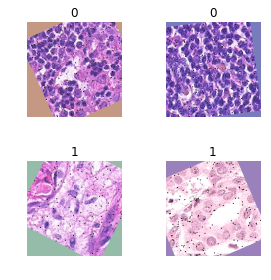

In [24]:
# check that the imgDataBunch is loading our images ok   检查imageDataBunch是否正确加载您的图像
imgDataBunch.show_batch(rows=2, figsize=(4,4)) 

# Baseline model构建基线模型(使用的库是：Fastai v1)
In ML production pipeline, it is a good idea to start with a relatively simple model, sort of a minimum viable product (MVP) or a baseline. With MVP, we can very quickly see if there are some unexpected problems like bad data quality that will make any further investments into the model tuning not worth it.  
在机器学习生产流程中，从一个相对简单的模型开始，比如最小可行结果（MVP）或基线是一个好主意。 通过MVP，我们可以非常快速地看到是否存在一些意想不到的问题，例如糟糕的数据质量，这将使得对模型调优的任何进一步投入都不值得。

## What kind of model architecture suits the problem best?什么模型最适合这个问题？  

We will use [**Fast.ai V1**](https://docs.fast.ai/) software library that is built on [PyTorch](https://pytorch.org/). What I like about Fast.ai is that it includes "out of the box" support for many recent advancements in deep learning research. If you want to use the 0.7 version of Fast.ai, see commit version 9 of this kernel.  
我们将使用基于PyTorch构建的Fast.ai V1软件库。 我对Fast.ai的喜欢之处在于它包含了对开展深度学习研究的最新进展的“开箱即用”(fan:一行代码完成很多复杂的事情)的支持。 如果要使用0.7版本的Fast.ai，请参阅此内核(原作者)的提交版本9。  

I highly recommend the [Fastai: practical deep learning course for coders, v3](https://course.fast.ai/).  
我强烈推荐Fastai：为编程员提供实用的深度学习课程，v3  

I want to thank [Martijn](https://www.kaggle.com/etinuz) for sharing his examples of Fastai v1 training and visualization! They were helpful when converting this kernel from Fastai v0.7 to v1.0.  
我要感谢Martijn分享他的Fastai v1训练和可视化示例！ 将此内核从Fastai v0.7转换为v1.0时，它们非常有用。  

Here we will be using a pretrained convnet model and transfer learning to adjust the weights to our data. Going for a deeper model architecture will start overfitting faster.  
在这里，<font color='blue'>我们将使用预训练的卷积神经网络模型(这里是densenet169)并做迁移学习来调整我们的权重</font>。用更深的模型架构将更快地发生过拟合。  

For differenet pretrained model architectures, check [Fast.ai vision models](https://docs.fast.ai/vision.models.html) and [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html).    
对于不同的*预训练模型架*构，请查看Fast.ai视觉模块和torchvision模块。

pcam benchmark 基准用的是GDensenet  
https://github.com/basveeling/pcam#benchmark  
densenet论文：  
Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger; The IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2017, pp. 4700-4708  
https://arxiv.org/pdf/1608.06993.pdf  
李沐关于densenet的解释：http://zh.gluon.ai/chapter_convolutional-neural-networks/densenet.html  

In [25]:
import torchvision
import os
arch = torchvision.models.densenet.densenet169  
# specify model architecture, densenet169 seems to perform well for this data but you could experiment
# 指定已经训练好的模型结构，densenet169似乎对这些数据表现良好，但是你也可以试试其他的

# 模型的保存地址
MODEL_PATH = os.path.join('histo/models',str(arch).split()[1])   # this will extrat the model name as the model file name e.g. 'resnet50' 分割字符串取第二个
# str(arch)  --->  '<function densenet169 at 0x7f618d9cdf28>'
# str(arch).split()[1] --->  densenet169

In [26]:
print(MODEL_PATH,str(arch))

histo/models/densenet169 <function densenet169 at 0x7f2aa7fd7378>


## 定义learner：确定数据、模型、预训练权重、评价指标、随机失活等
We define a convnet learner object where we set the model architecture and our data bunch.  
我们定义了一个卷积神经网络学习器对象，我们在其中设置模型体系结构和数据集。
[`create_cnn` docs.fast.ai(现在已改为cnn_learner)](https://docs.fast.ai/vision.learner.html#cnn_learner)

In [39]:
# Next, we create a convnet learner object 创建一个卷积神经网络学习器对象

def getLearner(): 
    return create_cnn(imgDataBunch, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)
#   `create_cnn` becomes `cnn_learner` 这个方法在新版本中改为cnn_learner 。 https://docs.fast.ai/vision.learner.html#cnn_learner
#   imgDataBunch是之前的定义的数据生成器 
#   arch = densenet169 选择模型
#   ps = dropout percentage (0-1) in the final layer  ps是最后一层随机失活的比例
#   pretrained如果是false则参数随机初始化，否则网络的backbone会被冻结，head会被用来训练。 the backbone will be frozen if you choose pretrained=True (so only the head will train if you call fit) 
#   metrics=accuracy 评测指标是准确率  https://docs.fast.ai/metrics.html#metrics
#   (loss_func: FlattenedLoss类 具体需要通过pycharm查看调用了哪个损失函数  https://docs.fast.ai/layers.html#FlattenedLoss  )
#   (opt_func:Callable=Adam  默认优化器)
#   callback_fns=ShowGraph 显示学习器的状态和评测指标  Update a graph of learner stats and metrics after each epoch.      https://docs.fast.ai/train.html#ClassificationInterpretation.most_confused
#   默认会自动把arch模型的最后一个卷积层后面的网络剪去，并自动加上一些网络使得模型输出与数据的类别个数相等。
#   custom_head为空，会自动设置模型的head
#   cut 为空，会自动切掉backbone的最后卷积层之后的网络
#   lin_ftrs 和 ps参数  用来定义head，如果不声明，会自动定义head
learner = getLearner() # 创建一个卷积神经网络学习器


# 设置超参数的一些想法(https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy)
# In his opinion, the batch size should be set to the highest possible value to fit in the available memory.
# Then the other hyper-parameters we may have (dropout for instance) can be tuned the same way as weight decay, 
# or just by trying on a cycle and see the results they give. The only thing is to never forget to re-run the 
# Learning Rate Finder, especially when deciding to pick a strategy with an aggressive learning rate close to 
# the maximum possible value.


/home/julyedu_465286/.local/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
/usr/local/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [31]:
learner.summary # https://docs.fast.ai/callbacks.hooks.html#model_summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,1,0,0
Path: histo;

Valid: LabelList (44005 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,1
Path: histo;

Test: LabelList (10 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: histo, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _Dense

In [32]:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 48, 48]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 48, 48]         128        True      
______________________________________________________________________
ReLU                 [64, 48, 48]         0          False     
______________________________________________________________________
MaxPool2d            [64, 24, 24]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 24, 24]         128        True      
______________________________________________________________________
ReLU                 [64, 24, 24]         0          False     
______________________________________________________________________
Conv2d               [128, 24, 24]        8,192      False     
___________________________________________________

 # Training 训练

In [28]:
print("julyedu")

julyedu


训练总体描述：  
In practice, you need to change the last part of your model to be adapted to your own number of classes. Most convolutional models end with a few linear layers (a part we will call the head). The last convolutional layer will have analyzed features in the image that went through the model, and the job of the head is to convert those in predictions for each of our classes. In transfer learning we will keep all the convolutional layers (called the body or the backbone of the model) with their weights pretrained on ImageNet but will define a new head initialized randomly.  

Then we will train the model we obtain in two phases: first we freeze the body weights and only train the head (to convert those analyzed features into predictions for our own data), then we unfreeze the layers of the backbone (gradually if necessary) and fine-tune the whole model (possibly using differential learning rates).

## 训练1cycle policy (1cycle策略)  

### 简单描述
Leslie 并不建议直接从大学习率开始，相反，他认为应该从低到高，达到最大的学习率(下面会讲解如何找到这个最大学习率)，缓慢地线性提升学习率，然后再用相同的时间缓慢地线性降低回来。  
https://blog.csdn.net/qq_38906523/article/details/80590314   
Sylvian Gugger wrote a very clear [explanation](https://sgugger.github.io/the-1cycle-policy.html) of Leslie's proposal that I recommend for reading.  
Sylvian Gugger写了一篇非常明确的文章解释Leslie的建议，我建议你阅读。https://sgugger.github.io/the-1cycle-policy.html 

学习率-迭代次数(batch)的变化关系图：
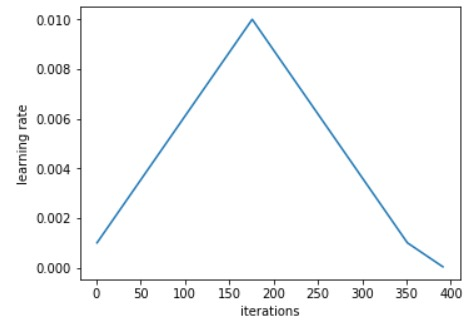  
(右图momentum这里没用到可以不用看)  

1cycle策略主要包括两个部分：  
1.选择最大学习率和衰减权重  
2.根据1cycle策略进行训练  

### 为什么要用1cycle策略？
We will use the one cycle policy proposed by Leslie Smith, [arXiv, April 2018](https://arxiv.org/abs/1803.09820). The policy brings more disciplined approach for selecting hyperparameters such as learning rate and weight decay.** This can potentially save us a lot of time from training with suboptimal hyperparameters.** In addititon, Fastai library has implemented a training function for one cycle policy that we can use with only a few lines of code.  
我们将使用Leslie Smith提出的一个周期策略。 该策略为选择超参数（例如学习率和衰减权重）带来了更加严谨的方法。**这可以为我们节省大量时间，使用次优的超参数进行训练。**另外，Fastai库为一个周期政策实施了训练函数， 我们只需几行代码即可使用。  


简单说：让模型收敛更快，过拟合程度更低，并且不用人工选择学习率超参数。  
https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy  

Here, we will dig into the first part of Leslie Smith's work about setting hyper-parameters (namely learning rate, momentum and weight decay). In particular, his 1cycle policy gives very fast results to train complex models. As an example, we'll see how it allows us to train a resnet-56 on cifar10 to the same or a better precision than the authors in their original paper but with far less iterations.  

By training with high learning rates we can reach a model that gets 93% accuracy in 70 epochs which is less than 7k iterations (as opposed to the 64k iterations which made roughly 360 epochs in the original paper).  

The idea of starting slower isn't new: using a lower value to warm-up the training is often done, and this is exactly what the first part is achieving. Leslie doesn't recommend to switch to a higher value directly, however, but to rather slowly go there linearly, and to take as much time going up as going down.  

What he observed during his experiments is that the during the middle of the cycle, the high learning rates will act as regularization method, and keep the network from overfitting. They will prevent the model to land in a steep area of the loss function, preferring to find a minimum that is flatter. He explained in this other paper how he observed that by using this policy, approximates of the hessian were lower, indicating that the SGD was finding a wider flat area.  

Then the last part of the training, with descending learning rates up until annihilation will allow us to go inside a steeper local minimum inside that smoother part. During the par with high learning rates, we don't see substantial improvements in the loss or the accuracy, and the validation loss sometimes spikes very high, but we see all the benefits of doing this when we finally lower the learning rates at the end.  


### 选择最大学习率和衰减权重

First, we find the optimal `learning rate` and `weight decay` values. The optimal lr is just before the base of the loss and before the start of divergence. It is important that the loss is still descending where we select the learning rate.  
首先，我们要找到最佳的“学习率”和“权重衰减”值。训练迭代过程，学习率会从小变大，最佳学习率应在损失函数的最低点之前和在开始发散之前。 重要的是，在我们选择最大学习率的地方，损失值应仍在下降。  

As for the `weight decay` that is the L2 penalty of the [](http://)optimizer, Leslie proposes to select the largest one that will still let us train at a high learning rate so we do a small grid search with 1e-2, 1e-4 and 1e-6 weight decays.  
对于作为优化器的L2惩罚项的“权重衰减”，Leslie建议选择最大并的仍可以让我们以高学习率训练的衰减权重，因此我们用1e-2、1e-4、1e-6衰减权重进行小型网格搜索。  

参考博客：  
https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate  
How do you decide on a learning rate? If it's too slow, your neural net is going to take forever to learn (try to use 10−5 instead of 10−2 in the previous article for instance). But if it's too high, each step you take will go over the minimum and you'll never get to an acceptable loss. Worse, a high learning rate could lead you to an increasing loss until it reaches nan.  

So we have to pick exactly the right value, not too high and not too low. For a long time, it's been a game of try and see, but in this article another approach is presented. Over an epoch begin your SGD with a very low learning rate (like 10−8) but change it (by multiplying it by a certain factor for instance) at each mini-batch until it reaches a very high value (like 1 or 10). Record the loss each time at each iteration and once you're finished, plot those losses against the learning rate. You'll find something like this:
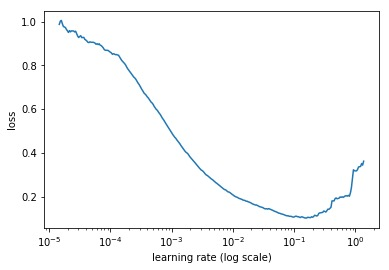  
The loss decreases at the beginning, then it stops and it goes back increasing, usually extremely quickly. That's because with very low learning rates, we get better and better, especially since we increase them. Then comes a point where we reach a value that's too high and the phenomenon shown before happens. Looking at this graph, what is the best learning rate to choose? Not the one corresponding to the minimum.  

Why? Well the learning rate that corresponds to the minimum value is already a bit too high, since we are at the edge between improving and getting all over the place. We want to go one order of magnitude before, a value that's still aggressive (so that we train quickly) but still on the safe side from an explosion. In the example described by the picture above, for instance, we don't want to pick 10−1 but rather 10−2.  

This method can be applied on top of every variant of SGD, and any kind of network. We just have to go through one epoch (usually less) and record the values of our loss to get the data for our plot.  




In [29]:
print("julyedu")

julyedu


In [40]:
# 1cycle策略，得到在不同权重衰减系数和学习率下 的损失值
# We can use lr_find with different weight decays and record all losses so that we can plot them on the same graph  
# 我们可以使用具有不同衰减权重的lr_find并记录所有损失值，以便我们可以在同一图表上绘制它们
# Number of iterations is by default 100, but at this low number of itrations, there might be too much variance
# 默认情况下，迭代次数为100，但如果次数比较少，可能会有比较高的方差
# from random sampling that makes it difficult to compare WD's. I recommend using an iteration count of at least 300 for more consistent results.
# 随机抽样，很难比较WD(权重衰减)的效果。 我建议使用至少300的迭代计数以获得更一致的结果。
lrs = [] # 用于记录学习率
losses = [] # 用于记录损失值
wds = [] # 用于记录衰减权重
iter_count = 600 # 寻找最优学习率的迭代批次batch数(下图中点的个数，也是学习率改变的次数)

# 1) WEIGHT DECAY = 1e-6  : 衰减权重是1e-6
learner.lr_find(wd=1e-6, num_it=iter_count) 
# lr_find 找到最大的不会让损失函数激增的学习率
# 论文：https://arxiv.org/abs/1506.01186
# wd权重衰减  
# num_it 寻找最优学习率的迭代批次batch数
# api:https://docs.fast.ai/basic_train.html#lr_find
lrs.append(learner.recorder.lrs) # 把寻找过程的学习率保存到lrs数组中
# recorder : 记录了epoch轮次、loss损失值、opt优化器、metric指标    https://docs.fast.ai/basic_train.html#Recorder
losses.append(learner.recorder.losses) # 把寻找过程的损失值保存到losses数组中
wds.append('1e-6') # 把寻找过程的的衰减权重保存到wds数组中




LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


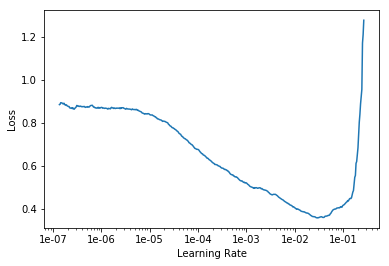

In [41]:
learner.recorder.plot()

In [42]:
# 2） WEIGHT DECAY = 1e-4  : 衰减权重是1e-4
learner = getLearner() #reset learner - this gets more consistent starting conditions 重设学习器
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')




/home/julyedu_465286/.local/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
/usr/local/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


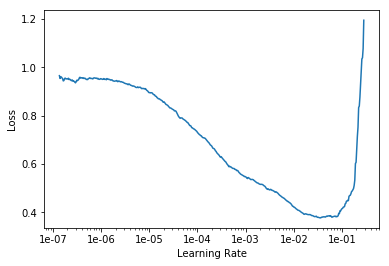

In [43]:
learner.recorder.plot()

In [46]:
# 3） WEIGHT DECAY = 1e-2  : 衰减权重是1e-2
learner = getLearner() #reset learner - this gets more consistent starting conditions 重设学习器
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
 #reset learner

/home/julyedu_465286/.local/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
/usr/local/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


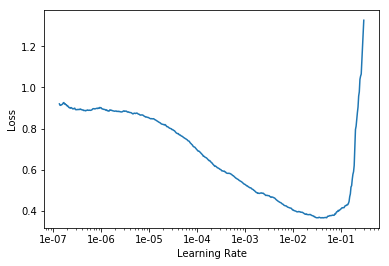

In [47]:
learner.recorder.plot()

In [31]:
print("julyedu")

julyedu


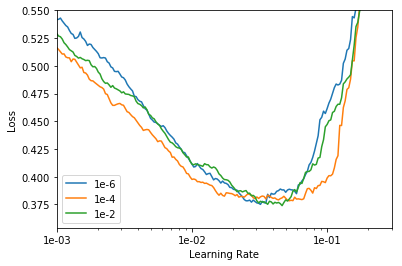

In [34]:

# Plot weight decays 画出三种权重衰减值下的 学习率与损失值的关系图
_, ax = plt.subplots(1,1) # 创建一个子图
min_y = 0.5 
max_y = 0.55 
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i]) # 在图中画出学习率-损失值对
    min_y = min(np.asarray(losses[i]).min(), min_y) # 找到损失最小值
ax.set_ylabel("Loss") # y轴标签是Loss
ax.set_xlabel("Learning Rate") # x轴标签是Learning Rate
ax.set_xscale('log') # x轴尺度是log对数
#ax ranges may need some tuning with different model architectures 当使用不同的模型时，ax的范围可能需要做调整
ax.set_xlim((1e-3,3e-1)) # 设置x轴上界和下界 
ax.set_ylim((min_y - 0.02,max_y)) # 设置y轴上界和下界
ax.legend(wds) # 图例 (1e-6 1e-4 1e-2) 
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e')) # 设置x轴标签文本的格式

选择最大学习率和衰减权重的思考：  
** We want to select the largest weight decay that gets to a low loss and has the highest learning rate before shooting up.**  
我们希望在停止下降前选择较大的衰减权重、并能得到较低的损失值、并且具有最高的学习率。  
Out of the tested WD's, 1e-4 seems like the largest WD that allow us to train with maximal learning rate. *Note that the plot above may differ between runs as we use a random subset of data for computations.*  
经测试，1e-4似乎是满足上述要求最大的衰减权重，它允许我们以更大的学习速度进行训练。 *请注意，上图可能在不同的运行之间有所不同，因为我们使用随机数据集进行计算。  

> Smaller datasets and architectures seem to require larger values for weight decay while larger datasets and deeper architectures seem to require smaller values.[Leslie  Smith](https://arxiv.org/pdf/1803.09820.pdf)  
较小的数据集和模型结构似乎需要较大的权重衰减值，而较大的数据集和较深的模型结构似乎需要较小的值https://arxiv.org/pdf/1803.09820.pdf。  

We can select the `learning rate` around 2e-2 where it is close to the bottom but still descending.  
我们可以在2e-2附近选择“学习率”，因为它接近损失函数的极值点但仍然在下降。  



### 1cycle冻结head进行训练

He recommends to do a cycle with two steps of equal lengths, one going from a lower learning rate to a higher one than go back to the minimum. The maximum should be the value picked with the Learning Rate Finder, and the lower one can be ten times lower. Then, the length of this cycle should be slightly less than the total number of epochs, and, in the last part of training, we should allow the learning rate to decrease more than the minimum, by several orders of magnitude.  
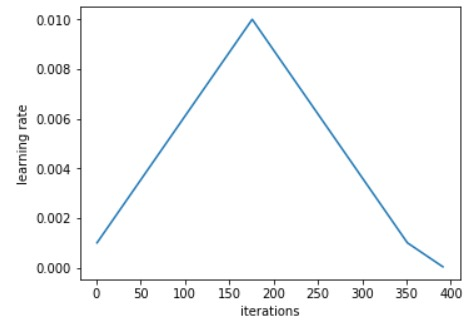  


The idea of starting slower isn't new: using a lower value to warm-up the training is often done, and this is exactly what the first part is achieving. Leslie doesn't recommend  


Next, we train only the heads while keeping the rest of the model frozen. Otherwise, the random initialization of the head weights could harm the relatively well-performing pre-trained weights of the model. After the heads have adjusted and the model somewhat works, we can continue to train all the weights.  
接下来，我们只训练模型的head，同时保持模型的其余部分(backbone)冻结。 否则(如果不冻结backbone)，head权重的随机初始化可能损害模型的相对良好的预训练权重。当head调整好并且模型比较好后，我们可以继续训练所有权重(backbone+head)。  

参考博客：  
https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy  


In [33]:
print("julyedu")

julyedu


epoch,train_loss,valid_loss,accuracy,time
0,0.239803,0.249178,0.903670,04:46
1,0.220569,0.226889,0.914760,04:43
2,0.193531,0.242191,0.906238,04:42
3,0.191862,0.194526,0.929190,04:44
4,0.171650,0.176434,0.933894,04:42
5,0.156093,0.148974,0.944711,04:43
6,0.141726,0.154780,0.949574,04:44
7,0.136456,0.132792,0.951256,04:42


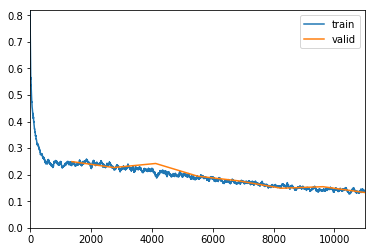

In [48]:
max_lr = 2e-2 # 之前能选到的最大的学习率 
wd = 1e-4 # 之前能选到的最大的权重衰减值
# 1cycle policy
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd) 
# cyc_len: epoch训练轮数
# 根据1cycle策略拟合模型  https://docs.fast.ai/train.html#fit_one_cycle
# https://docs.fast.ai/basic_train.html#fit_one_cycle
# wd：衰减权重
# max_lr one_cycle中的最大学习率 

In [35]:
print("julyedu")

julyedu


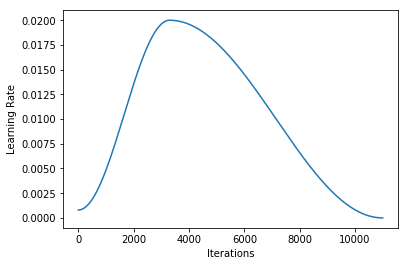

In [49]:
# plot learning rate of the one cycle 画出1cycle策略的学习率曲线 可以看到训练过程的学习率是由小变大、再由大变小
learner.recorder.plot_lr() #  https://docs.fast.ai/basic_train.html#Recorder.plot_lr

We can see that the learning rate starts from lower and reaches the `max_lr` in the middle. Then it slows back down near the end. The idea is that we start with a low warm-up learning rate and gradually increase it to high. The higher rate is having a regularizing effect as it won't allow the model to settle for sharp and narrow local minima but pushes for wider and more stable one.  
我们可以看到学习率从较低值开始增加到中间的“最大学习率max_lr”，然后又慢慢减小回来。  

1）我们的想法是，我们从低的学习率开始训练，然后逐渐将学习率提高到较高的值。较高的学习率具有正则化的效应，因为更大的学习率不允许模型留在尖锐和狭窄的局部最小值，而是趋向于更宽和更稳定的地方。  

2）In the middle of our cycle, we start to lower the learning rate as we are hopefully in a good stable area. This means that we start to look for the minima within that area.  
在我们训练的中期，我们开始降低学习率，因为我们觉得已处于一个良好的稳定区域。 这意味着我们开始寻找该区域内的局部最小值。

## Is the model learning?我们的模型学习了吗？
Our model should have already learned something and if it hasn't, there's probably something wrong with our code or with the data.   
我们的模型应该已经学到了东西，如果没有，则我们的代码或数据可能有问题。

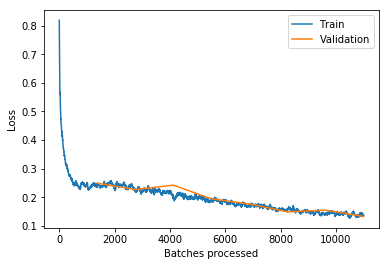

In [50]:
# and plot the losses of the first cycle 
learner.recorder.plot_losses() # 画出训练集和测试集的损失曲线  https://docs.fast.ai/basic_train.html#Recorder.plot_losses

We can see from the plotted losses that there is a small rise after the initial drop which is caused by the increasing learning rate of the first half cycle. The losses are temporarily rising when `max_lr` drives the model out of local minima but this will pay off in the end when the learning rates are decreased.  
我们可以从绘制的损失曲线中看出，损失值下降之后又存在小的上升，这是由于前半段的学习率增加引起的。学习率达到`max_lr`会使得模型out of局部最小值时，损失暂时上升，但是当学习率降低时，这将最终得到回报。

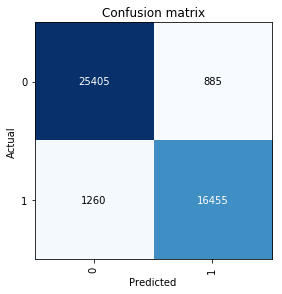

In [51]:
# predict the validation set with our model 验证集上模型的表现：
interp = ClassificationInterpretation.from_learner(learner) # 分类模型的预测效果展示函数 https://docs.fast.ai/vision.learner.html#ClassificationInterpretation
interp.plot_confusion_matrix(title='Confusion matrix') # 画出混淆矩阵 https://docs.fast.ai/train.html#ClassificationInterpretation.plot_confusion_matrix

**Confusion matrix** can help us understand the ratio of false negatives and positives and it's a fast way looking at our model's performance. This is a simple table that shows the counts in a way of actual label vs. predicted label. Here we can see that the model has learned to distinguish tumor and negative sample and it's already performing well. However, we will continue training further to improve from here.  
混淆矩阵可以帮助我们理解 假负例 和 假正例 的比例，这是一种快速查看模型性能的方法。这是一个简单的表格，以实际标签与预测标签对的方式计数。在这里我们可以看到该模型已经学会区分肿瘤样本 和 负例样本(没有肿瘤)，并且它分类表现良好。但是，我们将继续从这里微调。

In [54]:
MODEL_PATH='densenet169'
print(MODEL_PATH)

densenet169


In [55]:
# before we continue, lets save the model at this stage  在我们继续之前，让我们保存这个模型为densenet169_stage1
learner.save(MODEL_PATH + '_stage1')

## 1cycle冻结全部网络进行训练
Next, we can unfreeze all the trainable parameters from the model and continue its training.   
接下来，我们可以解冻模型中的所有可训练参数 然后继续训练。  

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.    
该模型(backbone冻结的)已经表现良好，现在，解冻已经使用大规模一般图像( ImageNet)进行预训练的底部网络(backbone)，所有层的权重都会被调整。 我们现在应该以更低的学习率进行训练。

In [40]:
print("julyedu")

julyedu


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


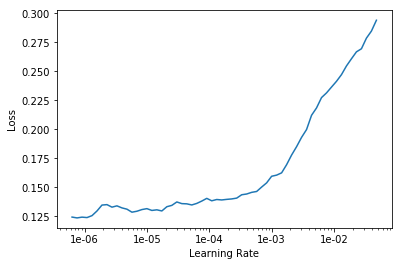

In [56]:
# load the baseline model 加载之前保存的基线模型权重
learner.load(MODEL_PATH + '_stage1')
 
# unfreeze and run learning rate finder again 
learner.unfreeze() # 解冻所有神经网络层
learner.lr_find(wd=wd) # wd是之前找到的最大衰减权重  次寻找最大学习率，以应用到1cycle学习策略中

# plot learning rate finder results 画出寻找学习率的过程
learner.recorder.plot()  

In [42]:
print("julyedu")

julyedu


epoch,train_loss,valid_loss,accuracy,time
0,0.141078,0.131079,0.951778,06:17
1,0.138676,0.129792,0.952005,06:18
2,0.145637,0.130402,0.952233,06:20
3,0.143752,0.137309,0.951051,06:17
4,0.130221,0.125497,0.954301,06:19
5,0.135574,0.126284,0.953437,06:20
6,0.128994,0.129722,0.951733,06:23
7,0.122154,0.113914,0.958755,06:20
8,0.114615,0.115604,0.961186,06:20
9,0.112771,0.103528,0.962482,06:22


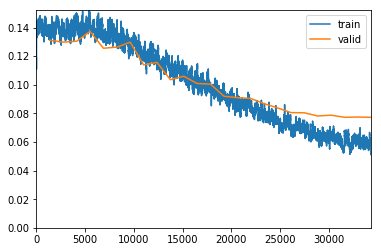

In [57]:
# Now, smaller learning rates. This time we define the min and max lr of the cycle 现在，学习率较低。 这次我们定义循环的最小和最大学习率
learner.fit_one_cycle(cyc_len=25, max_lr=slice(4e-5,4e-4)) # 根据1cycle策略训练模型  https://docs.fast.ai/train.html#fit_one_cycle
# cyc_len : epoch训练轮数
# max_lr=slice(4e-5,4e-4)
# lr_range 不同层有不同的学习率,从小到大。
# The bottom of the slice and the top of the slice is the difference between how quickly the lowest layer of the model learns versus the highest layer of the model learns. 
# As you go from layer to layer, we decrease the learning rate. 
# The lowest levels are given smaller learning rates so as not to disturb the weights much.

In [44]:
print("julyedu")

julyedu


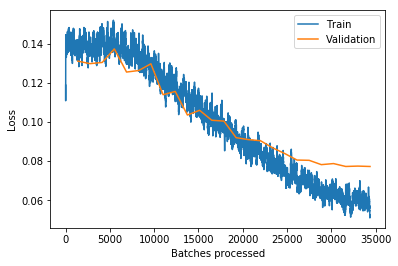

In [58]:
learner.recorder.plot_losses() # 画出训练集和验证集的损失 https://docs.fast.ai/basic_train.html#Recorder.plot_losses

We can see that the validation performance has separated from the training performance a bit in the end of the cycle. This means that our model has started overfitting during the small learning rates. Now, if we would train further, the model would only memorize features from the training set and the validation set performance would rise. This is a good place to stop.    
我们可以看到验证集损失函数在周期快结束时与训练集损失函数分离了一些。 这意味着我们的模型在小学习率期间开始过拟合。现在，如果我们继续训练，模型将只记住训练集中的特征，而验证集损失值会提高，所以 这是一个停止训练的好地方(早停)。

In [46]:
print("julyedu")

julyedu


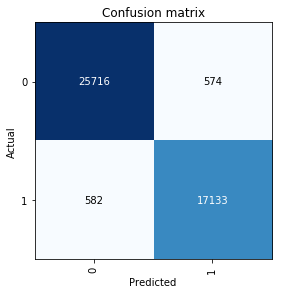

In [59]:
# lets take a second look at the confusion matrix. See if how much we improved. 让我们再看一下混淆矩阵。 看看我们改进了多少。
interp = ClassificationInterpretation.from_learner(learner)  # 分类模型的预测效果展示函数 https://docs.fast.ai/vision.learner.html#ClassificationInterpretation
interp.plot_confusion_matrix(title='Confusion matrix')  # 画出混淆矩阵 https://docs.fast.ai/train.html#ClassificationInterpretation.plot_confusion_matrix

In [48]:
print("julyedu")

julyedu


In [60]:
# Save the finetuned model
learner.save(MODEL_PATH + '_stage2') # 保存微调的模型

In [50]:
print("julyedu")

julyedu


In [51]:
# if the model was better before finetuning, uncomment this to load the previous stage 如果在微调之前的模型反而更好，则取消注释 ，加载前一阶段的模型，进行验证分析。
#learner.load(MODEL_PATH + '_stage1') 